  # Test of hierarchical classification (model 2)
  
  
  This model uses four layers. In the first layer, every source is classified hierarchically as Stochastic, Transient or Periodic. Then, every source pass trough the next layers (Stochastic, Transient and Periodic). The final classification is dertermined by multiplying the probabilities of the first layer, with their correspondant probabilites of the Stochastic, Transient and Periodic layers. For instance, the probability of being RRL corresponds to the product of the probability of being periodic (according to the first layer) and the probability of being RRL (according to the periodic layer): 
 
 $$Prob_{final}(RRL) = Prob_{first \: layer}(Periodic)* Prob_{periodic \: layer}(RRL)$$
 
 And the probability of being a Blazar is computed as:
 
  $$Prob_{final}(Blazar) = Prob_{first \: layer}(Stochastic)* Prob_{stochastic \: layer}(Blazar)$$


 
 The final classification is definded by the maximum $Prob_{final}$
 


In [1]:
import numpy as np
import pandas as pd
from sklearn import preprocessing, model_selection, metrics, ensemble
import pickle
import itertools
import matplotlib.pyplot as plt
from collections import Counter
from imblearn.ensemble import BalancedRandomForestClassifier as RandomForestClassifier
from scipy.stats import randint as sp_randint
from sklearn.utils import class_weight

  ### Definition of names for plots and files

In [2]:
morethan5 = False

extragalactic = False
galactic = False

date = '20200110'

#names of files with detections, features and labels for the training set (v3)
labels_file = '../alerce_trainingset/training_set_v5.1/dfcrossmatches_prioritized_v5.1.csv'
#detections_file = '../alerce_trainingset/training_set_v3/detections.pkl'
#features_file = '../alerce_trainingset/training_set_v3/features.pkl'
features_file = '../ZTF_data/features_20200109_with_WISE.csv'
#features_file = '../ZTF_data/features_20191017_filtered.pkl'
#non_detections_file = '../alerce_trainingset/training_set_v3/training_non_det_v3.h5'

class_output = '../ZTF_classifications/classes_TS_v5.1_new_features_with_WISE_'+date+'.csv'
#where the RF models are saved
if morethan5:
    model_first_layer = 'stat_prob_hierRF_model_2/rf_model_2_hierarchical_layer_morethan5gr_'+date
    model_periodic_layer = 'stat_prob_hierRF_model_2/rf_model_2_periodic_layer_morethan5gr_'+date
    model_transient_layer = 'stat_prob_hierRF_model_2/rf_model_2_transient_layer_morethan5gr_'+date
    model_stochastic_layer = 'stat_prob_hierRF_model_2/rf_model_2_stochastic_layer_morethan5gr_'+date

else: 
    model_first_layer = 'stat_prob_hierRF_model_2/rf_model_2_hierarchical_layer_'+date
    model_periodic_layer = 'stat_prob_hierRF_model_2/rf_model_2_periodic_layer_'+date
    model_transient_layer = 'stat_prob_hierRF_model_2/rf_model_2_transient_layer_'+date
    model_stochastic_layer = 'stat_prob_hierRF_model_2/rf_model_2_stochastic_layer_'+date

#confusion matrixes
if morethan5:
    conf_matrix_name_first_layer = 'stat_prob_hierRF_model_2/confusion_matrix_rf_model_2_hierarchical_layer_morethan5gr_'+date
    conf_matrix_name_second_layer = 'stat_prob_hierRF_model_2/confusion_matrix_rf_model_2_multiclass_morethan5gr_'+date

else:
    conf_matrix_name_first_layer = 'stat_prob_hierRF_model_2/confusion_matrix_rf_model_2_hierarchical_layer_'+date
    conf_matrix_name_second_layer = 'stat_prob_hierRF_model_2/confusion_matrix_rf_model_2_multiclass_'+date


#feature importances
if morethan5:
    feature_importance_name_first_layer = 'stat_prob_hierRF_model_2/feature_importance_rf_model_2_hierarchical_layer_morethan5gr_'+date
    feature_importance_name_periodic_layer = 'stat_prob_hierRF_model_2/feature_importance_rf_model_2_periodic_layer_morethan5gr_'+date
    feature_importance_name_transient_layer = 'stat_prob_hierRF_model_2/feature_importance_rf_model_2_transient_layer_morethan5gr_'+date
    feature_importance_name_stochastic_layer = 'stat_prob_hierRF_model_2/feature_importance_rf_model_2_stochastic_layer_morethan5gr_'+date
    
else: 
    feature_importance_name_first_layer = '../../paper_late_classifier/feature_importance_rf_model_2_hierarchical_layer_'+date+'.pdf'
    feature_importance_name_periodic_layer = '../../paper_late_classifier/feature_importance_rf_model_2_periodic_layer_'+date+'.pdf'
    feature_importance_name_transient_layer = '../../paper_late_classifier/feature_importance_rf_model_2_transient_layer_'+date+'.pdf'
    feature_importance_name_stochastic_layer = '../../paper_late_classifier/feature_importance_rf_model_2_stochastic_layer_'+date+'.pdf'

In [3]:
alerceclasses = { 'TDE': "TDE",
                  'Nova': "CV/Nova",
                  'CV': "CV/Nova",
                  'SN Ia-91bg-like': "SNIa",
                  'SN Ia': "SNIa",
                  'SN Ia-91T-like': "SNIa",
                  'SN Ia-CSM': "SNIa",
                  'SN Ia-pec': "SNIa",
                  'SN Iax[02cx-like]': "SNIa",
                  'SN Ib': "SNIbc",
                  'SN Ib-Ca-rich': "SNIbc",
                  'SN Ib-pec': "SNIbc",
                  'SN Ib/c': "SNIbc",
                  'SN Ibn': "SNIbc",
                  'SN Ic': "SNIbc",
                  'SN Ic-BL': "SNIbc",
                  'SN Ic-pec': "SNIbc",
                  'SN IIb': "SNIIb",
                  'SN II': "SNII",
                  'SN II-pec' : "SNII",
                  'SN IIL': "SNII",
                  'SN IIP': "SNII",
                  'SN IIn': "SNIIn",
                  'SN IIn-pec': "SNIIn",
                  'SLSN-I': "SLSN",
                  'SLSN-II': "SLSN",
                  'AGN': "",
                  'QSO': "",
                  'Impostor-SN': "",
                  'Kilonova': "",
                  'ILRT': "",
                  'LBV': "",
                  'M dwarf': "",
                  'Varstar': "",
                  'Galaxy': "",
                  'SN': "",
                  'SN I': "",
                  'Unknown': ""}


def encode(y):
    return y.apply(lambda x: alerceclasses[x])

### reading the training set files 

In [4]:
#df_nd = pd.read_hdf(non_detections_file)
df_feat = pd.read_csv(features_file,index_col='oid')
df_labels = pd.read_csv(labels_file,index_col='oid')


#df_wise = pd.read_csv(features_wise,index_col='oid')

#'''
df_feat['W2-W3']=df_feat['W2']-df_feat['W3']
df_feat.loc[(df_feat['W3']==np.nan) |(df_feat['W2']==np.nan) |(df_feat['W2']==-999)|(df_feat['W3']==-999), 'W2-W3']=np.nan

df_feat['r-W3']=df_feat['Mean_2']-df_feat['W3']
df_feat.loc[(df_feat['Mean_2']==np.nan) |(df_feat['W3']==np.nan) | (df_feat['Mean_2']==-999)|(df_feat['W3']==-999) , 'r-W3']=np.nan
df_feat.loc[(df_feat['r-W3']>500) | (df_feat['r-W3']<-500) ,'r-W3']=np.nan 

df_feat['r-W2']=df_feat['Mean_2']-df_feat['W2']
df_feat.loc[(df_feat['Mean_2']==np.nan) |(df_feat['W2']==np.nan) | (df_feat['Mean_2']==-999)|(df_feat['W2']==-999), 'r-W2']=np.nan
df_feat.loc[(df_feat['r-W2']>500) | (df_feat['r-W3']<-500),'r-W2']=np.nan 

df_feat['g-W3']=df_feat['Mean_1']-df_feat['W3']
df_feat.loc[(df_feat['Mean_1']==np.nan) |(df_feat['W3']==np.nan) | (df_feat['Mean_1']==-999)|(df_feat['W3']==-999) , 'g-W3']=np.nan
df_feat.loc[(df_feat['g-W3']>500) | (df_feat['g-W3']<-500) ,'g-W3']=np.nan

df_feat['g-W2']=df_feat['Mean_1']-df_feat['W2']
df_feat.loc[(df_feat['Mean_1']==np.nan) |(df_feat['W2']==np.nan) | (df_feat['Mean_1']==-999)|(df_feat['W2']==-999), 'g-W2']=np.nan
df_feat.loc[(df_feat['g-W2']>500) | (df_feat['g-W3']<-500),'g-W2']=np.nan
#'''

df_feat.to_csv('../ZTF_data/features_20200109_with_WISE_4_Hackathon.csv')

#df_detections = pd.read_pickle(detections_file)
'''
df_paps = pd.read_pickle(features_paps)
df_paps = df_paps.set_index('oid')
df_paps.paps_ratio_1=df_paps.paps_ratio_1.astype(float)
df_paps.paps_ratio_2=df_paps.paps_ratio_2.astype(float)
df_paps.paps_high_2=df_paps.paps_high_2.astype(float)
df_paps.paps_high_1=df_paps.paps_high_1.astype(float)
df_paps.paps_low_2=df_paps.paps_low_2.astype(float)
df_paps.paps_low_1=df_paps.paps_low_1.astype(float)

print(df_paps.dtypes)

df_paps = df_paps.replace([np.inf, -np.inf], np.nan)
df_paps.replace([-99], -999,inplace=True)
df_paps.fillna(-999,inplace=True)
print(np.max(df_paps['paps_ratio_2']))

'''

#deleting columns in df_nd with name ending in "_3"
#for col in list(df_nd):
#    if col[-2:] == "_3":
#        df_nd.drop(col, inplace=True, axis=1)

#getting gscore from the detections file
#df_det = df_detections.groupby(['oid'])
#df_sgscore = df_det['sgscore1'].median()
#df_sgscore = df_sgscore.to_frame()

#creating color features
#df_nd["g_r_max"] = df_nd.min_mag_fid_1 - df_nd.min_mag_fid_2
#df_feat["g_r_mean"] = df_feat.Mean_1 - df_feat.Mean_2

#discarging infinite values
df_feat = df_feat.replace([np.inf, -np.inf], np.nan)

print(df_labels['class_source'].values.size)
print(df_labels.head())

170976
             classALeRCE          ra        dec               period  \
oid                                                                    
ZTF19aavdfaf     CV/Nova  323.746659  40.671826         NON PERIODIC   
ZTF19aaniokz     CV/Nova  306.822433  43.689485               0.0777   
ZTF18accatjz     CV/Nova  331.153495  53.506598                  NaN   
ZTF19aarfrrf     CV/Nova  271.876088  45.858938  0.19362100000000002   
ZTF19aarfrre     CV/Nova  271.876073  45.859003  0.19362100000000002   

                      source id_source class_source  separation_arcsec  
oid                                                                     
ZTF19aavdfaf  CVsJavierAbril  V630 Cyg           CV           0.556391  
ZTF19aaniokz  CVsJavierAbril  V503 Cyg           CV           1.159315  
ZTF18accatjz  CVsJavierAbril    IV Cep           CV           0.742104  
ZTF19aarfrrf  CVsJavierAbril    DQ Her           CV           0.157008  
ZTF19aarfrre  CVsJavierAbril    DQ Her           C

In [5]:
#creating new labels to combine SNII and SNIIb classes, and to add RS-CVn as a new class
df_labels['class_original'] = df_labels['classALeRCE']
df_labels.loc[(df_labels['class_source'] == 'RSCVn'), 'class_original'] = 'Periodic-Other'
df_labels.loc[(df_labels['class_original'] == 'SNIIn'), 'class_original'] = 'SNII'
df_labels.loc[(df_labels['class_original'] == 'EA'), 'class_original'] = 'EB'
df_labels.loc[(df_labels['class_original'] == 'EB/EW'), 'class_original'] = 'EB'
#df_labels.loc[(df_labels['class_original'] == 'AGN-I'), 'class_original'] = 'QSO-I'
#df_labels.loc[(df_labels['class_source'] == 'A') | (df_labels['class_source'] == 'AGN_galaxy_dominated'), 'class_original'] = 'AGN-I'





#defining the classes included in the RF model
#label_order = ['QSO','AGN', 'Blazar', 'CV/Nova', 'YSO', 'SNIa', 'SNIbc', 'SNII',
#               'SLSN', 'EA', 'EB/EW', 'DSCT', 'RRL', 'Ceph', 'LPV','RSCVn','Periodic-Other']

label_order = ['QSO','AGN', 'Blazar', 'CV/Nova', 'YSO','LPV', 'SNIa', 'SNIbc', 'SNII',
               'SLSN', 'EB', 'DSCT', 'RRL', 'Ceph','Periodic-Other']

labels = df_labels.loc[df_labels.class_original.isin(label_order)][["class_original"]]

#defining hierarchical classes:

labels['class_hierachical'] = labels['class_original']

#labels.loc[(labels['class_hierachical'] == 'RSCVn') | (labels['class_hierachical'] == 'Periodic-Other') | (labels['class_hierachical'] == 'EA') | (labels['class_hierachical'] == 'EB/EW')  | (labels['class_hierachical'] == 'DSCT') | (labels['class_hierachical'] == 'RRL') | (labels['class_hierachical'] == 'Ceph') , 'class_hierachical'] = 'Periodic'
labels.loc[(labels['class_hierachical'] == 'RSCVn') | (labels['class_hierachical'] == 'Periodic-Other') | (labels['class_hierachical'] == 'EB')  | (labels['class_hierachical'] == 'DSCT') | (labels['class_hierachical'] == 'RRL') | (labels['class_hierachical'] == 'Ceph') , 'class_hierachical'] = 'Periodic'

labels.loc[(labels['class_hierachical'] == 'SNIa') | (labels['class_hierachical'] == 'SNIbc') | (labels['class_hierachical'] == 'SNII') | (labels['class_hierachical'] == 'SLSN'), 'class_hierachical'] = 'Transient'

labels.loc[(labels['class_hierachical'] == 'YSO') | (labels['class_hierachical'] == 'LPV') | (labels['class_hierachical'] == 'CV/Nova')  |   (labels['class_hierachical'] == 'AGN') |  (labels['class_hierachical'] == 'QSO') | (labels['class_hierachical'] == 'Blazar')  , 'class_hierachical'] = 'Stochastic'

cm_classes_hierachical = ['Stochastic','Transient','Periodic']
cm_classes_original = label_order

print(labels['class_hierachical'].values.shape)
labels.head()

(169358,)


,class_original,class_hierachical
oid,,
ZTF19aavdfaf,CV/Nova,Stochastic
ZTF19aaniokz,CV/Nova,Stochastic
ZTF18accatjz,CV/Nova,Stochastic
ZTF19aarfrrf,CV/Nova,Stochastic
ZTF19aarfrre,CV/Nova,Stochastic


In [6]:
#defining columns excluded from the df_nd table

rm_nd_cols = [
'n_det_1',
'n_det_2',
'n_pos_1',
'n_pos_2',
'n_neg_1',
'n_neg_2',
'first_mag_1',
'first_mag_2',
'aps_non_zero_1',
'aps_non_zero_2',
'mean_mag_1',
'mean_mag_2',
'min_mag_1',
'min_mag_2',
'W1','W2','W3','W4','u','g','r','i','z','u_g','g_r','r_i','i_z',  
'iqr_1',
'iqr_2', 
'delta_mjd_fid_1',
'delta_mjd_fid_2',   
]
'''
'max_mjd_fid_1',
'max_mjd_fid_2',
'min_mjd_fid_1',
'min_mjd_fid_2',
'max_mag_fid_1',
'max_mag_fid_2',
'min_mag_fid_1',
'min_mag_fid_2',
'first_mag_fid_1',
'first_mag_fid_2',
'first_mjd_fid_1',
'first_mjd_fid_2']
'''


#print(df_paps.columns)
#paps_drop = ['paps_non_zero_1','paps_PN_flag_1','paps_non_zero_2','paps_PN_flag_2']
#paps_drop = ['paps_non_zero_1','paps_non_zero_2']

wise_drop = ['W1','W2','W3','W4','u','g','r','i','z','u_g','g_r','r_i','i_z']

#rm_nd_cols = rm_nd_cols + wise_drop


#combining all the DF
#df = labels.join(df_sgscore).join(df_feat).join(df_nd.drop(rm_nd_cols, axis=1))
#df = labels.join(df_sgscore).join(df_feat.drop(rm_nd_cols, axis=1))

df = labels.join(df_feat.drop(rm_nd_cols, axis=1),how='inner')#.join(df_wise.drop(wise_drop, axis=1),how='left')
print(df['g-r_max'].values.size)
#df = df.join(df_wise.drop(wise_drop, axis=1),how='left')
#print(df['g-r_max'].values.size)
df = df.replace([np.inf, -np.inf], np.nan)
print(df['g-r_max'].values.size)
df_train = df.copy()
df_train = df_train.fillna(-999)
labels = df[['class_original','class_hierachical']]
df.drop(['Mean_1','Mean_2','class_original','class_hierachical'], axis=1, inplace=True)
df = df.fillna(-999)

#print(np.max(df['paps_ratio_2'].values))
#print(len(labels['class_original'].values))
#labels = labels.loc[df.index.values]
print(len(labels['class_original'].values))



print(df['g-r_max'].values.size)
df.head()

115941
115941
115941
115941


,Amplitude_1,Amplitude_2,AndersonDarling_1,AndersonDarling_2,Autocor_length_1,Autocor_length_2,Beyond1Std_1,Beyond1Std_2,Con_1,Con_2,...,positive_fraction_1,positive_fraction_2,rb,sgscore1,W1-W2,W2-W3,r-W3,r-W2,g-W3,g-W2
oid,,,,,,,,,,,,,,,,,,,,,
ZTF18abcoxgp,1.777660,1.612033,1.0,1.0,6.0,8.0,0.607143,0.626866,0.018519,0.000000,...,0.125000,0.194030,0.886667,0.983125,-999.000,-999.000,-999.000000,-999.000000,-999.000000,-999.000000
ZTF18aaavxnm,1.545494,1.355183,1.0,1.0,1.0,1.0,0.100000,0.163636,0.000000,0.018868,...,0.700000,0.763636,0.808571,1.000000,0.439,1.925,4.700925,2.775925,4.654902,2.729902
ZTF18abmefme,1.741148,1.508885,1.0,1.0,1.0,1.0,0.529412,0.521739,0.000000,0.000000,...,0.431373,0.413043,0.912857,0.996042,0.168,2.829,4.799764,1.970764,4.865939,2.036939
ZTF17aabumpu,1.689769,1.102787,1.0,1.0,1.0,1.0,0.176471,0.315789,0.000000,0.000000,...,0.735294,0.631579,0.846667,0.790198,0.026,0.576,2.432245,1.856245,2.667624,2.091624
ZTF18aazmwvg,2.734478,2.477687,1.0,1.0,2.0,3.0,0.428571,0.442623,0.021277,0.000000,...,0.571429,0.655738,0.807857,0.980625,0.440,3.472,4.365933,0.893933,4.910711,1.438711


In [7]:
#print(df.columns)
print(np.array(df.columns))
print(len(np.array(df.columns)))

['Amplitude_1' 'Amplitude_2' 'AndersonDarling_1' 'AndersonDarling_2'
 'Autocor_length_1' 'Autocor_length_2' 'Beyond1Std_1' 'Beyond1Std_2'
 'Con_1' 'Con_2' 'Eta_e_1' 'Eta_e_2' 'ExcessVar_1' 'ExcessVar_2'
 'GP_DRW_sigma_1' 'GP_DRW_sigma_2' 'GP_DRW_tau_1' 'GP_DRW_tau_2' 'Gskew_1'
 'Gskew_2' 'Harmonics_mag_1_1' 'Harmonics_mag_1_2' 'Harmonics_mag_2_1'
 'Harmonics_mag_2_2' 'Harmonics_mag_3_1' 'Harmonics_mag_3_2'
 'Harmonics_mag_4_1' 'Harmonics_mag_4_2' 'Harmonics_mag_5_1'
 'Harmonics_mag_5_2' 'Harmonics_mag_6_1' 'Harmonics_mag_6_2'
 'Harmonics_mag_7_1' 'Harmonics_mag_7_2' 'Harmonics_mse_1'
 'Harmonics_mse_2' 'Harmonics_phase_2_1' 'Harmonics_phase_2_2'
 'Harmonics_phase_3_1' 'Harmonics_phase_3_2' 'Harmonics_phase_4_1'
 'Harmonics_phase_4_2' 'Harmonics_phase_5_1' 'Harmonics_phase_5_2'
 'Harmonics_phase_6_1' 'Harmonics_phase_6_2' 'Harmonics_phase_7_1'
 'Harmonics_phase_7_2' 'IAR_phi_1' 'IAR_phi_2' 'LinearTrend_1'
 'LinearTrend_2' 'MaxSlope_1' 'MaxSlope_2' 'Meanvariance_1'
 'Meanvariance_2' 'Med

In [8]:
for idx, cl in enumerate(label_order):
   #print(idx, cl)
   print(cl, labels['class_original'][labels['class_original']==cl].shape[0])

QSO 11216
AGN 2369
Blazar 985
CV/Nova 794
YSO 1517
SNIa 799
SNIbc 51
SNII 218
SLSN 21
EB 33455
DSCT 663
RRL 29868
Ceph 567
LPV 33157
Periodic-Other 261


  ### Defining functions to plot the confusion matrix and the feature importance

In [50]:
def plot_confusion_matrix(cm, classes, plot_name,
                          normalize=True,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    
    if morethan5: title='Confusion matrix for more than 5 samples per band'
    if extragalactic: title='Confusion matrix for |gal_b|>20'
    if galactic: title='Confusion matrix for |gal_b|<=20'


    fig, ax = plt.subplots(figsize=(12, 10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    #plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.savefig(plot_name, bbox_inches='tight')
    #plt.close()
    
    
def plot_feature_importances(model, feature_names,feature_importances_name):
    I = np.argsort(model.feature_importances_)[::-1]
    I = I[0:60]
    for i in I[0:20]:
        print(feature_names[i], "& %.3f" % (model.feature_importances_[i]))
    fig, ax = plt.subplots(figsize=(16, 5), tight_layout=True)
    x_plot = np.arange(len(I))
    plt.xticks(x_plot, [feature_names[i] for i in I], rotation='vertical')
    ax.bar(x_plot, height=model.feature_importances_[I]);
    plt.savefig(feature_importances_name, bbox_inches='tight')
    #plt.close()

### Pre-processing training data

In [10]:
Y_hierarchical = labels['class_hierachical']#.values
Y_original = labels['class_original']#.values

print(len(labels['class_hierachical'].values))
print(len(labels['class_original'].values))
X_hierarchical = df#.columns.values.tolist()

#splitting training set
X_train_hierarchical, X_test_hierarchical, y_train_hierarchical, y_test_hierarchical, y_train_original, y_test_original  = model_selection.train_test_split(X_hierarchical,
          Y_hierarchical, Y_original, test_size=0.2, stratify=Y_original)


# separating training sets for sub-classes
X_train_periodic = X_train_hierarchical.loc[y_train_hierarchical=='Periodic', :]
#X_train_periodic.drop(['Mean_2'], axis=1,inplace=True)
y_train_periodic = y_train_original.loc[y_train_hierarchical=='Periodic']

X_train_stochastic = X_train_hierarchical.loc[y_train_hierarchical=='Stochastic', :]
y_train_stochastic = y_train_original.loc[y_train_hierarchical=='Stochastic']

X_train_transient = X_train_hierarchical.loc[y_train_hierarchical=='Transient', :]
#X_train_transient.drop(['Mean_2'], axis=1,inplace=True)
y_train_transient = y_train_original.loc[y_train_hierarchical=='Transient']

#X_train_hierarchical.drop(['Mean_2'], axis=1,inplace=True)

X_test_periodic = X_test_hierarchical#.drop(['Mean_2'], axis=1)
X_test_stochastic = X_test_hierarchical#.drop(['Mean_2'], axis=1)
X_test_transient = X_test_hierarchical#.drop(['Mean_2'], axis=1)
#X_test_hierarchical = X_test_hierarchical#.drop(['Mean_2'], axis=1)


print(len(y_train_periodic), len(y_train_stochastic), len(y_train_transient))

115941
115941
51851 40030 871


  ## Balanced random forest
  
  ### First layer: separating Periodic, Stochastic and Transients:

In [11]:
#Training first layer of the RF model

rf_model_hierarchical = RandomForestClassifier(
            n_estimators=500,
            max_features='auto',
            max_depth=None,
            n_jobs=-1,
            bootstrap=True,
            class_weight='balanced_subsample',
            criterion='entropy',
            min_samples_split=2,
            min_samples_leaf=1)


rf_model_hierarchical.fit(X_train_hierarchical, y_train_hierarchical)

#testing first layer performance

y_true, y_pred = y_test_hierarchical, rf_model_hierarchical.predict(X_test_hierarchical)
y_pred_proba_hier = rf_model_hierarchical.predict_proba(X_test_hierarchical)

classes_order_proba_hierarchical = rf_model_hierarchical.classes_
print(classes_order_proba_hierarchical)

#c = np.c_[y_pred_proba_hier, y_test_original]
#c = np.c_[c, y_pred_]
#print(c)

print("Accuracy:", metrics.accuracy_score(y_true, y_pred))
print("Balanced accuracy:", metrics.balanced_accuracy_score(y_true, y_pred))

#Dumping trained model

features_hierarchical = list(X_train_hierarchical)

with open(model_first_layer, 'wb') as pickle_file:
        model_dump = {
            'rf_model': rf_model_hierarchical,#rf_model_hierarchical,
            'features': features_hierarchical,
            'order_classes': classes_order_proba_hierarchical
            }
        pickle.dump(model_dump, pickle_file)

['Periodic' 'Stochastic' 'Transient']
Accuracy: 0.9843029022381301
Balanced accuracy: 0.9869576484304985


[[ 9721    66   221]
 [    1   217     0]
 [   69     7 12887]]
Normalized confusion matrix


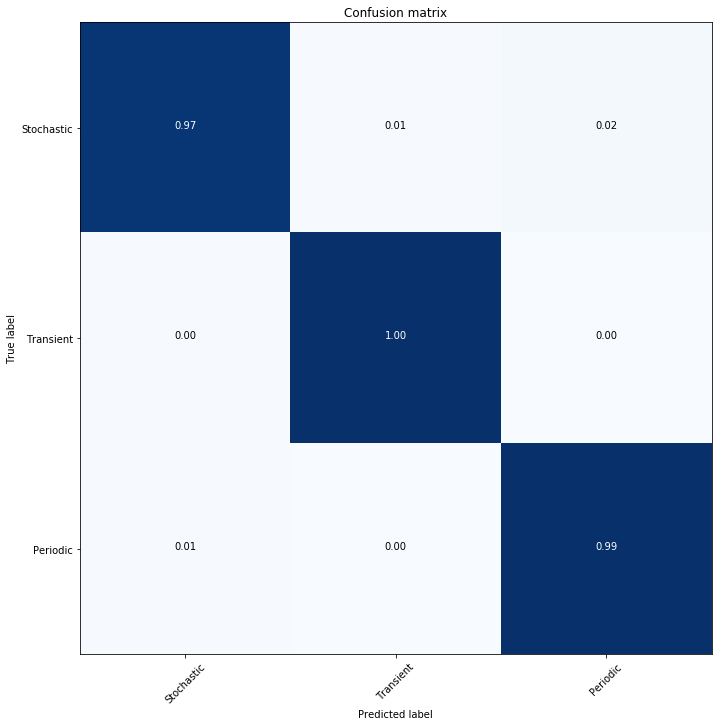

In [12]:
#plotting confusion matrix
cnf_matrix = metrics.confusion_matrix(y_true, y_pred, labels=cm_classes_hierachical)
print(cnf_matrix)
plot_confusion_matrix(cnf_matrix,cm_classes_hierachical,conf_matrix_name_first_layer)

sgscore1 & 0.075
g-W3 & 0.063
g-W2 & 0.058
positive_fraction_2 & 0.058
r-W2 & 0.058
LinearTrend_2 & 0.049
W1-W2 & 0.038
r-W3 & 0.033
aps_low_2 & 0.031
n_non_det_after_fid_2 & 0.026
W2-W3 & 0.023
Rcs_2 & 0.022
GP_DRW_tau_2 & 0.021
g-r_mean & 0.020
SF_ML_amplitude_2 & 0.020
IAR_phi_2 & 0.019
IAR_phi_1 & 0.018
g-r_max & 0.016
LinearTrend_1 & 0.016
Autocor_length_2 & 0.014


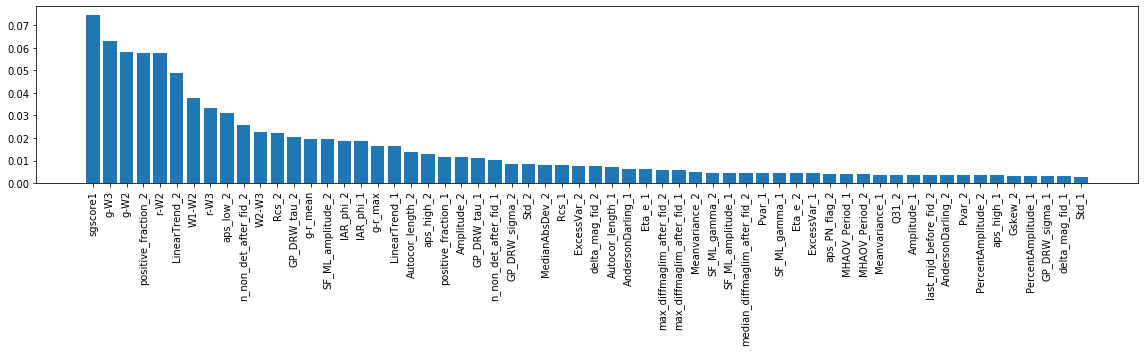

In [51]:
#plotting feature importance
plot_feature_importances(rf_model_hierarchical, features_hierarchical, feature_importance_name_first_layer)

  ### Periodic layer

In [14]:
#Training Periodic layer

rf_model_periodic = RandomForestClassifier(
            n_estimators=500,
            max_features='auto',
            max_depth=None,
            n_jobs=-1,
            class_weight='balanced_subsample',
            #bootstrap=False,
            criterion='entropy',
            min_samples_split=2,
            min_samples_leaf=1)

rf_model_periodic.fit(X_train_periodic, y_train_periodic)


# Applying periodic model to the test data
y_true_periodic, y_pred_periodic = y_test_original, rf_model_periodic.predict(X_test_periodic)
y_pred_proba_periodic = rf_model_periodic.predict_proba(X_test_periodic)

classes_order_proba_periodic = rf_model_periodic.classes_
print(classes_order_proba_periodic)

#Dumping trained model

features_periodic = list(X_train_periodic)

with open(model_periodic_layer, 'wb') as pickle_file:
        model_dump = {
            'rf_model': rf_model_periodic,
            'features': features_periodic,
            'order_classes': classes_order_proba_periodic
            }
        pickle.dump(model_dump, pickle_file)

['Ceph' 'DSCT' 'EB' 'Periodic-Other' 'RRL']


89
MHAOV_Period_1 & 0.071
g-W2 & 0.045
g-r_max & 0.033
MHAOV_Period_2 & 0.031
g-r_mean & 0.022
r-W2 & 0.022
delta_mag_fid_1 & 0.020
Amplitude_1 & 0.020
ExcessVar_1 & 0.019
rb & 0.016
GP_DRW_sigma_1 & 0.016
Std_1 & 0.016
Meanvariance_1 & 0.015
PercentAmplitude_1 & 0.015
Gskew_1 & 0.014
W1-W2 & 0.014
gal_b & 0.013
max_diffmaglim_after_fid_1 & 0.013
aps_low_1 & 0.013
W2-W3 & 0.013


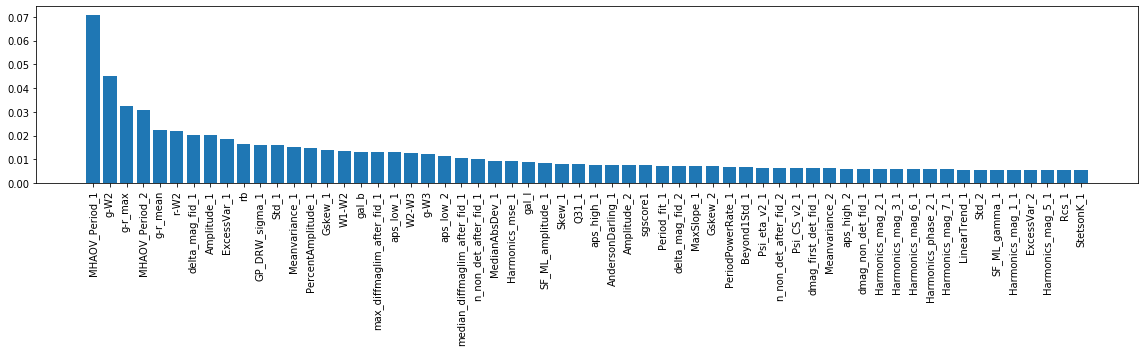

In [52]:
#plotting feature importance
print(len(feature_importance_name_first_layer))
plot_feature_importances(rf_model_periodic, features_periodic, feature_importance_name_periodic_layer)

  ### Stochastic layer

In [16]:
#Training Stochastic layer

rf_model_stochastic = RandomForestClassifier(
            n_estimators=500,
            max_features=0.2,#'auto',
            max_depth=None,
            n_jobs=-1,
            bootstrap=True,
            class_weight='balanced_subsample',
            criterion='entropy',
            min_samples_split=2,
            min_samples_leaf=1)

rf_model_stochastic.fit(X_train_stochastic, y_train_stochastic)


# Applying stochastic model to the test data
y_true_stochastic, y_pred_stochastic  = y_test_original, rf_model_stochastic.predict(X_test_stochastic)
y_pred_proba_stochastic = rf_model_stochastic.predict_proba(X_test_stochastic)

classes_order_proba_stochastic = rf_model_stochastic.classes_
print(classes_order_proba_stochastic)

#Dumping trained model

features_stochastic = list(X_train_stochastic)

with open(model_stochastic_layer, 'wb') as pickle_file:
        model_dump = {
            'rf_model': rf_model_stochastic,
            'features': features_stochastic,
            'order_classes': classes_order_proba_stochastic
            }
        pickle.dump(model_dump, pickle_file)

['AGN' 'Blazar' 'CV/Nova' 'LPV' 'QSO' 'YSO']


W1-W2 & 0.108
W2-W3 & 0.087
g-r_mean & 0.067
sgscore1 & 0.061
g-r_max & 0.052
g-W2 & 0.051
gal_b & 0.047
r-W2 & 0.046
g-W3 & 0.040
r-W3 & 0.029
gal_l & 0.018
ExcessVar_2 & 0.014
IAR_phi_1 & 0.014
Pvar_2 & 0.013
Meanvariance_2 & 0.011
GP_DRW_tau_1 & 0.011
IAR_phi_2 & 0.010
Amplitude_2 & 0.009
aps_high_2 & 0.009
Std_2 & 0.009


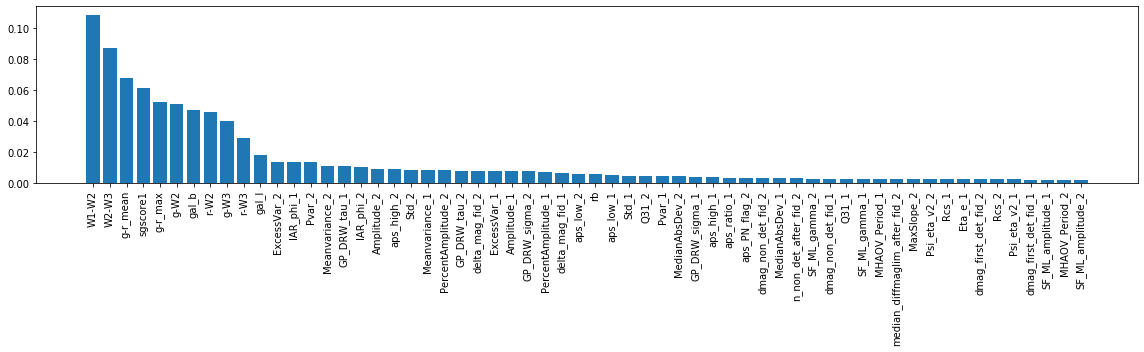

In [53]:
#plotting feature importance
plot_feature_importances(rf_model_stochastic, features_stochastic, feature_importance_name_stochastic_layer)

  ### Transient layer

In [18]:
#Training Transient layer

rf_model_transient = RandomForestClassifier(
            n_estimators=500,
            max_features='auto',
            max_depth=None,
            n_jobs=-1,
            bootstrap=True,
            class_weight='balanced_subsample',
            criterion='entropy',
            min_samples_split=2,
            min_samples_leaf=1)

rf_model_transient.fit(X_train_transient, y_train_transient)

# Applying transient model to the test data
y_true_transient, y_pred_transient  = y_test_original, rf_model_transient.predict(X_test_transient)
y_pred_proba_transient = rf_model_transient.predict_proba(X_test_transient)

classes_order_proba_transient = rf_model_transient.classes_
print(classes_order_proba_transient)

#Dumping trained model

features_transient = list(X_train_transient)

with open(model_transient_layer, 'wb') as pickle_file:
        model_dump = {
            'rf_model': rf_model_transient,
            'features': features_transient,
            'order_classes': classes_order_proba_transient
            }
        pickle.dump(model_dump, pickle_file)

['SLSN' 'SNII' 'SNIa' 'SNIbc']


g-r_max & 0.035
aps_low_1 & 0.029
LinearTrend_2 & 0.025
AndersonDarling_2 & 0.022
IAR_phi_1 & 0.020
IAR_phi_2 & 0.019
g-r_mean & 0.018
aps_ratio_1 & 0.017
SF_ML_amplitude_2 & 0.015
dmag_first_det_fid_2 & 0.015
LinearTrend_1 & 0.014
sgscore1 & 0.013
dmag_first_det_fid_1 & 0.013
GP_DRW_tau_2 & 0.013
GP_DRW_tau_1 & 0.011
aps_low_2 & 0.011
MedianAbsDev_2 & 0.011
Harmonics_mag_5_2 & 0.011
Harmonics_mag_2_2 & 0.011
dmag_non_det_fid_2 & 0.010


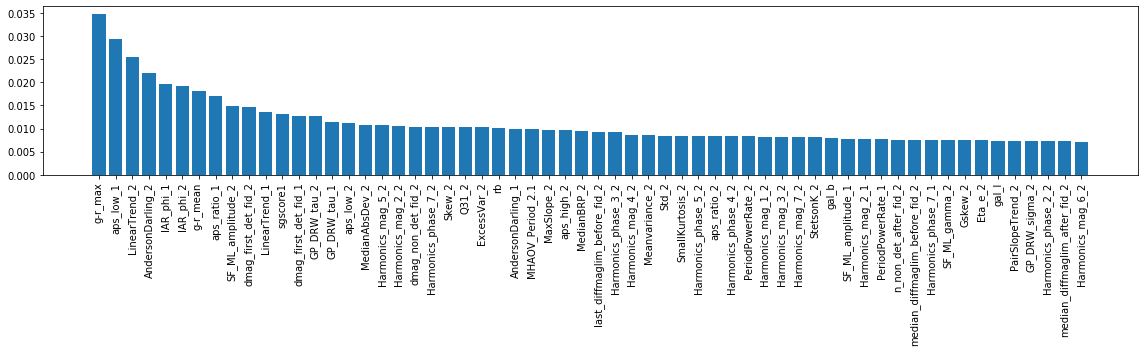

In [54]:
#plotting feature importance
plot_feature_importances(rf_model_transient, features_transient, feature_importance_name_transient_layer)

 ## Putting al layers together  


In [20]:
# generating final probabilities

#multiplying probabilities of the hierarchical layer with the other layers
prob_periodic = y_pred_proba_periodic*y_pred_proba_hier[:,np.where(classes_order_proba_hierarchical=='Periodic')[0][0]].T[:, np.newaxis]
prob_stochastic = y_pred_proba_stochastic*y_pred_proba_hier[:,np.where(classes_order_proba_hierarchical=='Stochastic')[0][0]].T[:, np.newaxis]
prob_trainsient = y_pred_proba_transient*y_pred_proba_hier[:,np.where(classes_order_proba_hierarchical=='Transient')[0][0]].T[:, np.newaxis]

#obtaining final probabilities matrix
prob_final = np.concatenate((prob_stochastic,prob_trainsient,prob_periodic),axis=1)

print(np.sum(prob_final,axis=1),np.mean(np.sum(prob_final,axis=1)),np.std(np.sum(prob_final,axis=1)))

#getting the ordered name of classes for prob_final
prob_final_class_names = np.concatenate((classes_order_proba_stochastic,classes_order_proba_transient,classes_order_proba_periodic))
print(prob_final_class_names)


class_final_proba = np.amax(prob_final,axis=1)
class_final_index = np.argmax(prob_final,axis=1)
class_final_name = [prob_final_class_names[x] for x in class_final_index]



[1. 1. 1. ... 1. 1. 1.] 1.0 8.711394857997552e-17
['AGN' 'Blazar' 'CV/Nova' 'LPV' 'QSO' 'YSO' 'SLSN' 'SNII' 'SNIa' 'SNIbc'
 'Ceph' 'DSCT' 'EB' 'Periodic-Other' 'RRL']


[[1860  246   89    2    1    0    1    1    4    1    2    1    0    0
    35]
 [  32  407   24    0    4    0    0    0    5    1    0    0    0    0
     1]
 [  40   15  133    3    1    0    1    0    0    0    0    1    0    0
     3]
 [   0    0    1   86    0    6    4    3    0    6   13   22    6    0
    12]
 [   0    0    6    2  255    0    0    2    0    4    0    3    4    8
    19]
 [   0    0    0    0    0  108   36   10    6    0    0    0    0    0
     0]
 [   0    0    0    0    0    3    4    2    1    0    0    0    0    0
     0]
 [   0    0    0    0    0   10    9   15   10    0    0    0    0    0
     0]
 [   0    1    0    0    0    0    0    0    3    0    0    0    0    0
     0]
 [   0    1    3   27   62    0    1    0    0 4356  575  195  269    0
  1202]
 [   0    0    0    0    0    0    0    0    0   11  110    4    3    1
     4]
 [   0    1    0    7    7    3    2    1    1  192  387 4689  112    1
   571]
 [   0    0    1    0    8    0    0    

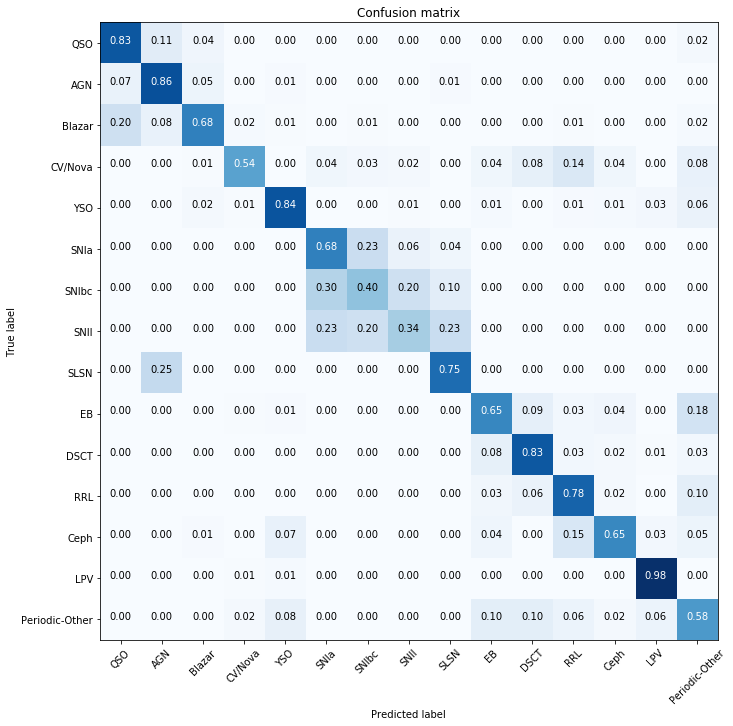

In [21]:
# generating confusion matrix for multilabels
cnf_matrix = metrics.confusion_matrix(y_test_original, class_final_name,labels=label_order)
print(cnf_matrix)
plot_confusion_matrix(cnf_matrix,label_order, conf_matrix_name_second_layer)

print("Accuracy:", "%0.2f" % metrics.accuracy_score(y_test_original, class_final_name))
print("Balanced accuracy:","%0.2f" %  metrics.balanced_accuracy_score(y_test_original, class_final_name))

print("weighted precision: ","%0.2f" %  metrics.precision_score(y_test_original, class_final_name, average='weighted'))
print("weighted recall: ","%0.2f" %  metrics.recall_score(y_test_original, class_final_name, average='weighted'))
print("weighted F1: ","%0.2f" %  metrics.f1_score(y_test_original, class_final_name, average='weighted'))



In [22]:
# Kaggle score

num_y_test =  class_final_index#[np.where(label_order==x)[0][0] for x in y_test_original] #label_encoder.transform(y_test)

class_weights = list(class_weight.compute_class_weight('balanced', label_order, y_test_original))

print(class_weights)

CLASSES_REDUCED_V2 = label_order

def kaggle_loss(labels, predictions, weights=None):
    np.clip(predictions, 10**-15, 1-10**-15, out=predictions)
    classes = np.unique(labels)
    if weights is None:
        weights = np.ones(len(classes), dtype=np.float64)/len(classes)
    loss_sum = 0
    labels = np.array(labels)
    for i in classes:
        p = predictions[labels == i, i]
        class_score = np.mean(np.log(p))*weights[i]
        print(CLASSES_REDUCED_V2[i], class_score)
        loss_sum += class_score
    return -loss_sum/sum(weights)



print(kaggle_loss(num_y_test,prob_final))

[0.6892257393371972, 3.261462728551336, 7.847377326565144, 9.722851153039832, 5.102090209020902, 9.662083333333333, 154.59333333333333, 35.13484848484848, 386.48333333333335, 0.23104667961938924, 11.623558897243107, 0.2587769222185024, 13.680825958702066, 0.23310213108162445, 29.72948717948718]
QSO -0.040829806832589056
AGN -0.05026757465234547
Blazar -0.07987580597064461
CV/Nova -0.011521540819074787
YSO -0.027410778144907666
SNIa -0.0443927938891143
SNIbc -0.08369971173169236
SNII -0.07998946911145187
SLSN -0.06822505732538266
EB -0.07941777187877146
DSCT -0.06855134621792902
RRL -0.06769870796778964
Ceph -0.052409206019732986
LPV -0.06983621454229735
Periodic-Other -0.04002510213402327
0.8641508872377467


In [23]:
''''''''

''

In [24]:
'''#2 bands
acc_mag_2band_stochastic=[]
acc_mag_2band_periodic=[]
acc_mag_2band_transient=[]

mag_2band_stochastic=[]
mag_2band_periodic=[]
mag_2band_transient=[]

for i in range(len(bins_mag)):
    df_test_2band_aux = df_test_2band[((df_test_2band['Mean_2']>=(bins_mag[i]-0.25)) & (df_test_2band['Mean_2']<(bins_mag[i]+0.25)))]
    #stochastics:
    df_test_2band_aux_stochastic = df_test_2band_aux[df_test_2band_aux['class_hierachical']=='Stochastic']
    true_y_stochastic = df_test_2band_aux_stochastic['class_original'].values
    pred_y_stochastic = df_test_2band_aux_stochastic['predicted_class'].values
    acc_stochastic = metrics.balanced_accuracy_score(true_y_stochastic, pred_y_stochastic)
    acc_mag_2band_stochastic.append(acc_stochastic)
    
    #periodics
    df_test_2band_aux_periodic = df_test_2band_aux[df_test_2band_aux['class_hierachical']=='Periodic']
    true_y_periodic = df_test_2band_aux_periodic['class_original'].values
    pred_y_periodic = df_test_2band_aux_periodic['predicted_class'].values
    acc_periodic = metrics.balanced_accuracy_score(true_y_periodic, pred_y_periodic)
    acc_mag_2band_periodic.append(acc_periodic)
    
    #transients
    df_test_2band_aux_transient = df_test_2band_aux[df_test_2band_aux['class_hierachical']=='Transient']
    print(len(df_test_2band_aux_transient['n_det_1'].values),bins_mag[i])
    true_y_transient = df_test_2band_aux_transient['class_original'].values
    pred_y_transient = df_test_2band_aux_transient['predicted_class'].values
    acc_transient = metrics.balanced_accuracy_score(true_y_transient, pred_y_transient)
    acc_mag_2band_transient.append(acc_transient)

acc_mag_2band_stochastic=np.array(acc_mag_2band_stochastic)
acc_mag_2band_periodic=np.array(acc_mag_2band_periodic)
acc_mag_2band_transient=np.array(acc_mag_2band_transient)

print(acc_mag_1band_stochastic)

plt.plot(bins_mag,acc_mag_2band_stochastic,'ro-',label='Stochastic')
plt.plot(bins_mag,acc_mag_2band_periodic,'bo-',label='Periodic')
plt.plot(bins_mag,acc_mag_2band_transient,'go-',label='Transient')
plt.legend()
plt.xlabel('mean mag')
plt.ylabel('Balanced Accuracy')'''

"#2 bands\nacc_mag_2band_stochastic=[]\nacc_mag_2band_periodic=[]\nacc_mag_2band_transient=[]\n\nmag_2band_stochastic=[]\nmag_2band_periodic=[]\nmag_2band_transient=[]\n\nfor i in range(len(bins_mag)):\n    df_test_2band_aux = df_test_2band[((df_test_2band['Mean_2']>=(bins_mag[i]-0.25)) & (df_test_2band['Mean_2']<(bins_mag[i]+0.25)))]\n    #stochastics:\n    df_test_2band_aux_stochastic = df_test_2band_aux[df_test_2band_aux['class_hierachical']=='Stochastic']\n    true_y_stochastic = df_test_2band_aux_stochastic['class_original'].values\n    pred_y_stochastic = df_test_2band_aux_stochastic['predicted_class'].values\n    acc_stochastic = metrics.balanced_accuracy_score(true_y_stochastic, pred_y_stochastic)\n    acc_mag_2band_stochastic.append(acc_stochastic)\n    \n    #periodics\n    df_test_2band_aux_periodic = df_test_2band_aux[df_test_2band_aux['class_hierachical']=='Periodic']\n    true_y_periodic = df_test_2band_aux_periodic['class_original'].values\n    pred_y_periodic = df_test_

In [25]:
'''#2 bands
acc_nsamp_2band_stochastic=[]
acc_nsamp_2band_periodic=[]
acc_nsamp_2band_transient=[]

nsamp_2band_stochastic=[]
nsamp_2band_periodic=[]
nsamp_2band_transient=[]

for i in range(len(bins_nsamp_2band)):
    df_test_2band_aux = df_test_2band[(((df_test_2band['n_det_1'].values+df_test_2band['n_det_2'].values)>=(bins_nsamp_2band[i]-10)) & ((df_test_2band['n_det_1'].values+df_test_2band['n_det_2'].values)<(bins_nsamp_2band[i]+10)))]
    print(len(df_test_2band_aux['n_det_1'].values),bins_nsamp_2band[i])
    #stochastics:
    df_test_2band_aux_stochastic = df_test_2band_aux[df_test_2band_aux['class_hierachical']=='Stochastic']
    true_y_stochastic = df_test_2band_aux_stochastic['class_original'].values
    pred_y_stochastic = df_test_2band_aux_stochastic['predicted_class'].values
    if (len(pred_y_stochastic))>4:
        acc_stochastic = metrics.balanced_accuracy_score(true_y_stochastic, pred_y_stochastic)
        acc_nsamp_2band_stochastic.append(acc_stochastic)
        nsamp_2band_stochastic.append(bins_nsamp_2band[i])

    #periodics
    df_test_2band_aux_periodic = df_test_2band_aux[df_test_2band_aux['class_hierachical']=='Periodic']
    true_y_periodic = df_test_2band_aux_periodic['class_original'].values
    pred_y_periodic = df_test_2band_aux_periodic['predicted_class'].values
    if (len(pred_y_periodic))>4:
        acc_periodic = metrics.balanced_accuracy_score(true_y_periodic, pred_y_periodic)
        acc_nsamp_2band_periodic.append(acc_periodic)
        nsamp_2band_periodic.append(bins_nsamp_2band[i])
        
    #transients
    df_test_2band_aux_transient = df_test_2band_aux[df_test_2band_aux['class_hierachical']=='Transient']
    true_y_transient = df_test_2band_aux_transient['class_original'].values
    pred_y_transient = df_test_2band_aux_transient['predicted_class'].values
    if (len(pred_y_transient))>4:
        acc_transient = metrics.balanced_accuracy_score(true_y_transient, pred_y_transient)
        acc_nsamp_2band_transient.append(acc_transient)
        nsamp_2band_transient.append(bins_nsamp_2band[i])

acc_nsamp_2band_stochastic=np.array(acc_nsamp_2band_stochastic)
acc_nsamp_2band_periodic=np.array(acc_nsamp_2band_periodic)
acc_nsamp_2band_transient=np.array(acc_nsamp_2band_transient)

nsamp_2band_stochastic=np.array(nsamp_2band_stochastic)
nsamp_2band_periodic=np.array(nsamp_2band_periodic)
nsamp_2band_transient=np.array(nsamp_2band_transient)



plt.plot(nsamp_2band_stochastic,acc_nsamp_2band_stochastic,'ro-',label='Stochastic')
plt.plot(nsamp_2band_periodic,acc_nsamp_2band_periodic,'bo-',label='Periodic')
plt.plot(nsamp_2band_transient,acc_nsamp_2band_transient,'go-',label='Transient')
plt.legend()
plt.xlabel('number of samples')
plt.ylabel('Balanced Accuracy')'''

"#2 bands\nacc_nsamp_2band_stochastic=[]\nacc_nsamp_2band_periodic=[]\nacc_nsamp_2band_transient=[]\n\nnsamp_2band_stochastic=[]\nnsamp_2band_periodic=[]\nnsamp_2band_transient=[]\n\nfor i in range(len(bins_nsamp_2band)):\n    df_test_2band_aux = df_test_2band[(((df_test_2band['n_det_1'].values+df_test_2band['n_det_2'].values)>=(bins_nsamp_2band[i]-10)) & ((df_test_2band['n_det_1'].values+df_test_2band['n_det_2'].values)<(bins_nsamp_2band[i]+10)))]\n    print(len(df_test_2band_aux['n_det_1'].values),bins_nsamp_2band[i])\n    #stochastics:\n    df_test_2band_aux_stochastic = df_test_2band_aux[df_test_2band_aux['class_hierachical']=='Stochastic']\n    true_y_stochastic = df_test_2band_aux_stochastic['class_original'].values\n    pred_y_stochastic = df_test_2band_aux_stochastic['predicted_class'].values\n    if (len(pred_y_stochastic))>4:\n        acc_stochastic = metrics.balanced_accuracy_score(true_y_stochastic, pred_y_stochastic)\n        acc_nsamp_2band_stochastic.append(acc_stochasti

  ## Analysis post classification in training set

In [26]:
oids_test = y_test_original.copy()#.index.values
oids_test = oids_test.to_frame()
classified_names = np.array(class_final_name)

oids_test['pred_class'] = classified_names

print(oids_test.head())

LPV_asAGN = oids_test.loc[(oids_test.class_original=='AGN-I') & (oids_test.pred_class=='QSO-I')].index.values
#LPV_asAGN = y_test_original.loc[y_test_original.values=='QSO-I']


print(LPV_asAGN) 

print(df.loc[LPV_asAGN])
test_csv = df.loc[LPV_asAGN]
test_csv.to_csv('~/Desktop/blazar_class_as_QSO.csv')


              class_original      pred_class
oid                                         
ZTF18acuewgn             RRL            DSCT
ZTF18acszbgp  Periodic-Other  Periodic-Other
ZTF18abnlwfl             LPV             LPV
ZTF18aamkbdx              EB              EB
ZTF18aaadsdn             LPV             LPV
[]
Empty DataFrame
Columns: [Amplitude_1, Amplitude_2, AndersonDarling_1, AndersonDarling_2, Autocor_length_1, Autocor_length_2, Beyond1Std_1, Beyond1Std_2, Con_1, Con_2, Eta_e_1, Eta_e_2, ExcessVar_1, ExcessVar_2, GP_DRW_sigma_1, GP_DRW_sigma_2, GP_DRW_tau_1, GP_DRW_tau_2, Gskew_1, Gskew_2, Harmonics_mag_1_1, Harmonics_mag_1_2, Harmonics_mag_2_1, Harmonics_mag_2_2, Harmonics_mag_3_1, Harmonics_mag_3_2, Harmonics_mag_4_1, Harmonics_mag_4_2, Harmonics_mag_5_1, Harmonics_mag_5_2, Harmonics_mag_6_1, Harmonics_mag_6_2, Harmonics_mag_7_1, Harmonics_mag_7_2, Harmonics_mse_1, Harmonics_mse_2, Harmonics_phase_2_1, Harmonics_phase_2_2, Harmonics_phase_3_1, Harmonics_phase_3_2, Harmonic

In [27]:
'''
import psycopg2
import json

credentials_file = "alercereaduser.json"
with open(credentials_file) as jsonfile:
    params = json.load(jsonfile)["params"]
    

conn = psycopg2.connect(dbname=params['dbname'], user=params['user'], host=params['host'], password=params['password'])
    
    
def plotLC(oid, SN_det, SN_nondet):
    fig, ax = plt.subplots(figsize = (10, 5))
    labels = {1: 'g', 2: 'r'}
    colors = {1: 'g', 2: 'r'}
    for fid in [1, 2]:
        mask = SN_det.fid == fid
        if np.sum(mask) > 0:            
            ax.errorbar(SN_det[mask].mjd, SN_det[mask].magpsf_corr, 
                yerr = SN_det[mask].sigmapsf_corr, c = colors[fid], marker = 'o', label = labels[fid])
        #mask = (SN_nondet.fid == fid) & (SN_nondet.diffmaglim > -900)
        #if np.sum(mask) > 0:            
        #    ax.scatter(SN_nondet[mask].mjd, SN_nondet[mask].diffmaglim, c = colors[fid], alpha = 0.5,
        #        marker = 'v', label = "lim.mag. %s" % labels[fid])
    ax.set_title(oid)
    ax.set_xlabel("MJD")
    ax.set_ylabel("Magnitude")
    ax.legend()
    ax.set_ylim(ax.get_ylim()[::-1])
    
    
def getSNdata(oid, doplot = False, doNED = False):

    # query detections and sort by mjd
    query="select oid, ra, dec, fid, mjd, magpsf_corr, sigmapsf_corr from detections where oid='%s'" % oid
    SN_det = pd.read_sql_query(query, conn)
    SN_det.sort_values(by=['mjd'], inplace=True)
        
    # query non detections and sort by mjd
    query="select oid, fid, mjd, diffmaglim from non_detections where oid='%s'" % oid
    SN_nondet = pd.read_sql_query(query, conn)
    SN_nondet.sort_values(by=['mjd'], inplace=True)
    
    if doplot:
        plotLC(oid, SN_det, SN_nondet)
        
    # find NED galaxies
    if doNED:
        co = coordinates.SkyCoord(ra=SNe.meanra[oid], dec=SNe.meandec[oid], unit=(u.deg, u.deg), frame='fk4')
        result_table = Ned.query_region(co, radius=0.01 * u.deg, equinox='J2000.0')
        display(result_table)
                
    # return data
    return SN_det, SN_nondet


for oid in LPV_asAGN:
    getSNdata(oid, doplot = True, doNED = False);
'''

'\nimport psycopg2\nimport json\n\ncredentials_file = "alercereaduser.json"\nwith open(credentials_file) as jsonfile:\n    params = json.load(jsonfile)["params"]\n    \n\nconn = psycopg2.connect(dbname=params[\'dbname\'], user=params[\'user\'], host=params[\'host\'], password=params[\'password\'])\n    \n    \ndef plotLC(oid, SN_det, SN_nondet):\n    fig, ax = plt.subplots(figsize = (10, 5))\n    labels = {1: \'g\', 2: \'r\'}\n    colors = {1: \'g\', 2: \'r\'}\n    for fid in [1, 2]:\n        mask = SN_det.fid == fid\n        if np.sum(mask) > 0:            \n            ax.errorbar(SN_det[mask].mjd, SN_det[mask].magpsf_corr, \n                yerr = SN_det[mask].sigmapsf_corr, c = colors[fid], marker = \'o\', label = labels[fid])\n        #mask = (SN_nondet.fid == fid) & (SN_nondet.diffmaglim > -900)\n        #if np.sum(mask) > 0:            \n        #    ax.scatter(SN_nondet[mask].mjd, SN_nondet[mask].diffmaglim, c = colors[fid], alpha = 0.5,\n        #        marker = \'v\', label 

  ## Classifying unlabeled data

In [28]:
#loading the data

#print(df_feat.n_det_1.size)
print(rm_nd_cols)

#rm_nd_cols = ['n_det_fid_1', 'n_det_fid_2', 'n_pos_1', 'n_pos_2', 'n_neg_1', 'n_neg_2',
#             'Mean_1','Mean_2','paps_non_zero_1','paps_non_zero_2']

'''rm_nd_cols = [
'n_det_1',
'n_det_2',
'n_pos_1',
'n_pos_2',
'n_neg_1',
'n_neg_2',
'Mean_1',
'Mean_2',
'paps_non_zero_1',
#'paps_PN_flag_1',
'paps_non_zero_2',
#'paps_PN_flag_2',
]'''

mean_drop = ['Mean_1','Mean_2']

df_feat_ul = df_feat.drop(rm_nd_cols, axis=1)
df_feat_ul = df_feat_ul.drop(mean_drop, axis=1)
#df_feat_ul = df_feat_ul.join(df_wise.drop(wise_drop, axis=1))
df_feat_ul = df_feat_ul.replace([np.inf, -np.inf], np.nan)
df_feat_ul.fillna(-999,inplace=True)

#print(df_feat_ul.n_det_1.size)

if extragalactic:
    df_feat_ul = df_feat_ul[(df_feat_ul.gal_b > 20) | (df_feat_ul.gal_b < -20)]

if galactic:
    df_feat_ul = df_feat_ul[(df_feat_ul.gal_b <= 20) & (df_feat_ul.gal_b >= -20)]
    
if morethan5:
    df_feat_ul = df_feat_ul[(df_feat_ul.n_det_1 > 5) & (df_feat_ul.n_det_2 > 5)]
    
df_feat_ul_out = df_feat_ul
    
#df_feat_ul_stochastic = df_feat_ul

#df_feat_ul = df_feat_ul.drop(['Mean_2'], axis=1)

df_feat_ul.head()


['n_det_1', 'n_det_2', 'n_pos_1', 'n_pos_2', 'n_neg_1', 'n_neg_2', 'first_mag_1', 'first_mag_2', 'aps_non_zero_1', 'aps_non_zero_2', 'mean_mag_1', 'mean_mag_2', 'min_mag_1', 'min_mag_2', 'W1', 'W2', 'W3', 'W4', 'u', 'g', 'r', 'i', 'z', 'u_g', 'g_r', 'r_i', 'i_z', 'iqr_1', 'iqr_2', 'delta_mjd_fid_1', 'delta_mjd_fid_2']


,Amplitude_1,Amplitude_2,AndersonDarling_1,AndersonDarling_2,Autocor_length_1,Autocor_length_2,Beyond1Std_1,Beyond1Std_2,Con_1,Con_2,...,positive_fraction_1,positive_fraction_2,rb,sgscore1,W1-W2,W2-W3,r-W3,r-W2,g-W3,g-W2
oid,,,,,,,,,,,,,,,,,,,,,
ZTF17aaaaaxg,0.200738,0.215184,1.0,1.000000,1.0,1.0,0.452381,0.450000,0.0,0.0,...,0.380952,0.350000,0.739524,0.894375,-0.056,1.655,3.797847,2.142847,4.394539,2.739539
ZTF17aaaadvq,-999.000000,0.316305,-999.0,1.000000,-999.0,1.0,-999.000000,0.055556,-999.0,0.0,...,-999.000000,0.944444,0.690000,0.982625,0.046,1.619,4.563254,2.944254,-999.000000,-999.000000
ZTF17aaaadyl,-999.000000,0.326172,-999.0,1.000000,-999.0,1.0,-999.000000,0.151515,-999.0,0.0,...,-999.000000,0.848485,0.690000,0.988732,-999.000,-999.000,-999.000000,-999.000000,-999.000000,-999.000000
ZTF17aaaafce,0.207151,0.198148,1.0,0.999998,1.0,1.0,0.513514,0.428571,0.0,0.0,...,0.243243,0.571429,0.696667,0.993333,-0.029,1.705,3.663143,1.958143,4.416657,2.711657
ZTF17aaaajfv,0.656590,0.488236,1.0,1.000000,1.0,1.0,0.634615,0.508621,0.0,0.0,...,0.442308,0.362069,0.768333,0.985083,-0.351,2.636,4.331154,1.695154,5.044343,2.408343


In [29]:
#predicting classes of unlabeled data


test_Y_hierarchical = rf_model_hierarchical.predict(df_feat_ul)
test_Y_proba_hierarchical = rf_model_hierarchical.predict_proba(df_feat_ul)

test_Y_periodic = rf_model_periodic.predict(df_feat_ul)
test_Y_proba_periodic = rf_model_periodic.predict_proba(df_feat_ul)

test_Y_stochastic = rf_model_stochastic.predict(df_feat_ul)
test_Y_proba_stochastic = rf_model_stochastic.predict_proba(df_feat_ul)

test_Y_transient = rf_model_transient.predict(df_feat_ul)
test_Y_proba_transient = rf_model_transient.predict_proba(df_feat_ul)


#multiplying probabilities
prob_periodic_ul = test_Y_proba_periodic*test_Y_proba_hierarchical[:,np.where(classes_order_proba_hierarchical=='Periodic')[0][0]].T[:, np.newaxis]
prob_stochastic_ul = test_Y_proba_stochastic*test_Y_proba_hierarchical[:,np.where(classes_order_proba_hierarchical=='Stochastic')[0][0]].T[:, np.newaxis]
prob_trainsient_ul = test_Y_proba_transient*test_Y_proba_hierarchical[:,np.where(classes_order_proba_hierarchical=='Transient')[0][0]].T[:, np.newaxis]

#obtaining final probabilities matrix
prob_final_ul = np.concatenate((prob_stochastic_ul,prob_trainsient_ul,prob_periodic_ul),axis=1)

print(np.sum(prob_final_ul,axis=1),np.mean(np.sum(prob_final_ul,axis=1)),np.std(np.sum(prob_final_ul,axis=1)))

#getting the ordered name of classes for prob_final
prob_final_class_names_ul = np.concatenate((classes_order_proba_stochastic,classes_order_proba_transient,classes_order_proba_periodic))
print(prob_final_class_names)


class_final_proba_ul = np.amax(prob_final_ul,axis=1)
class_final_index_ul = np.argmax(prob_final_ul,axis=1)
class_final_name_ul = [prob_final_class_names_ul[x] for x in class_final_index_ul]


[1. 1. 1. ... 1. 1. 1.] 1.0 9.217513741539284e-17
['AGN' 'Blazar' 'CV/Nova' 'LPV' 'QSO' 'YSO' 'SLSN' 'SNII' 'SNIa' 'SNIbc'
 'Ceph' 'DSCT' 'EB' 'Periodic-Other' 'RRL']


In [30]:
#Writing results in the output

df_out = df_feat
print(df_out.shape)
print(len(class_final_name_ul))
print(len(prob_final_ul))


df_out['predicted_class'] = class_final_name_ul
df_out['predicted_class_proba'] = class_final_proba_ul
test_data_withclass = df_out

#'''
probs_header = prob_final_class_names_ul + '_prob'

prob_pd_ul = pd.DataFrame(prob_final_ul,columns=probs_header,index=df_out.index)

prob_h_pd_ul = pd.DataFrame(test_Y_proba_hierarchical, columns=['prob_Periodic','prob_Stochastic','prob_Transient'],index=df_out.index)

test_data_withclass = df_out.join(prob_pd_ul).join(prob_h_pd_ul)

test_data_withclass.to_csv(class_output)

test_data_withclass.head()
#'''
#test_data_withclass.head()

(690527, 169)
690527
690527


,Amplitude_1,Amplitude_2,AndersonDarling_1,AndersonDarling_2,Autocor_length_1,Autocor_length_2,Beyond1Std_1,Beyond1Std_2,Con_1,Con_2,...,SNIa_prob,SNIbc_prob,Ceph_prob,DSCT_prob,EB_prob,Periodic-Other_prob,RRL_prob,prob_Periodic,prob_Stochastic,prob_Transient
oid,,,,,,,,,,,,,,,,,,,,,
ZTF17aaaaaxg,0.200738,0.215184,1.0,1.000000,1.0,1.0,0.452381,0.450000,0.0,0.0,...,0.000000,0.000000,0.053676,0.196812,0.630196,0.073556,0.039760,0.994,0.006,0.000
ZTF17aaaadvq,NaN,0.316305,NaN,1.000000,NaN,1.0,NaN,0.055556,NaN,0.0,...,0.005248,0.009344,0.161664,0.030312,0.200396,0.382268,0.067360,0.842,0.126,0.032
ZTF17aaaadyl,NaN,0.326172,NaN,1.000000,NaN,1.0,NaN,0.151515,NaN,0.0,...,0.017472,0.027552,0.087948,0.061424,0.235924,0.213588,0.099116,0.698,0.218,0.084
ZTF17aaaafce,0.207151,0.198148,1.0,0.999998,1.0,1.0,0.513514,0.428571,0.0,0.0,...,0.000388,0.000600,0.079680,0.209160,0.547800,0.113544,0.045816,0.996,0.002,0.002
ZTF17aaaajfv,0.656590,0.488236,1.0,1.000000,1.0,1.0,0.634615,0.508621,0.0,0.0,...,0.000000,0.000000,0.107784,0.005988,0.065868,0.045908,0.772452,0.998,0.002,0.000


In [31]:
test_data_withclass.shape

(690527, 189)

Counter({'EB': 181739, 'LPV': 169457, 'Periodic-Other': 143115, 'YSO': 54934, 'RRL': 46651, 'DSCT': 30929, 'Ceph': 25092, 'QSO': 17750, 'AGN': 7450, 'CV/Nova': 4435, 'Blazar': 2787, 'SNIbc': 2113, 'SNIa': 1914, 'SLSN': 1096, 'SNII': 1065})
                number
EB              181739
LPV             169457
Periodic-Other  143115
YSO              54934
RRL              46651
DSCT             30929
Ceph             25092
QSO              17750
AGN               7450
CV/Nova           4435
Blazar            2787
SNIbc             2113
SNIa              1914
SLSN              1096
SNII              1065


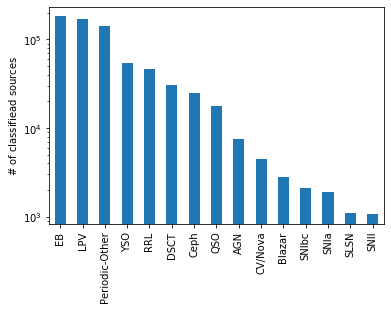

In [32]:
class_counts = Counter(class_final_name_ul)
class_counts.most_common()
print(class_counts)


df_hist = pd.DataFrame.from_dict(class_counts, orient='index',columns=['number'])
df_hist = df_hist.sort_values(by=['number'],ascending=False)
print(df_hist)
df_hist.plot(kind='bar',legend=False)

#plt.bar(class_counts.keys(), class_counts.values())
plt.yscale('log')
#plt.title('sources classified')
plt.ylabel(r'$\#$ of classifiead sources')
#plt.xlabel(r'class')
#df_hist.set_xticklabels(label_order)

plt.savefig('../../paper_late_classifier/paper_plots/number_classified_sources.pdf',bbox_inches='tight')

0 QSO 0.694512
1 AGN 0.5395479999999999
2 Blazar 0.442224
3 CV/Nova 0.2546
4 YSO 0.40032
5 LPV 0.7939679999999999
6 SNIa 0.342524
7 SNIbc 0.26376
8 SNII 0.19588
9 SLSN 0.255918
10 EB 0.37824
11 DSCT 0.331056
12 RRL 0.47615999999999997
13 Ceph 0.3024
14 Periodic-Other 0.33440000000000003


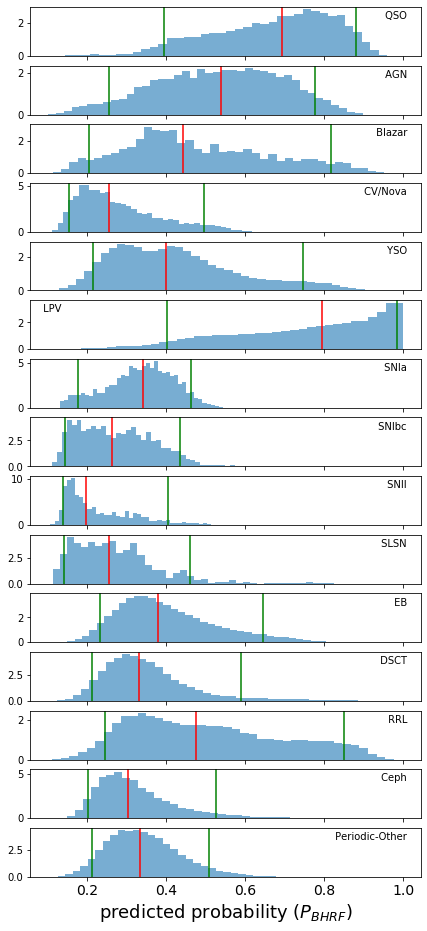

In [104]:
label_order = ['QSO','AGN', 'Blazar', 'CV/Nova', 'YSO','LPV', 'SNIa', 'SNIbc', 'SNII',
               'SLSN', 'EB', 'DSCT', 'RRL', 'Ceph','Periodic-Other']


fig, ax = plt.subplots(nrows = len(prob_final_class_names_ul), figsize=(7, 16), sharex=True)
for idx, cl in enumerate(label_order):
   #print(idx, cl)
   print(idx, cl, np.percentile(test_data_withclass['predicted_class_proba'][test_data_withclass['predicted_class']==cl].values, 50.))
   ax[idx].axvline(np.percentile(test_data_withclass['predicted_class_proba'][test_data_withclass['predicted_class']==cl].values, 5.), c='g')
   ax[idx].axvline(np.percentile(test_data_withclass['predicted_class_proba'][test_data_withclass['predicted_class']==cl].values, 50.), c='r')
   ax[idx].axvline(np.percentile(test_data_withclass['predicted_class_proba'][test_data_withclass['predicted_class']==cl].values, 95.), c='g')
   #ax[idx].axvline(1/len(prob_final_class_names_ul), c = 'k')
   nn,binsn,aux=ax[idx].hist(test_data_withclass['predicted_class_proba'][test_data_withclass['predicted_class']==cl].values, density=True, histtype='stepfilled', bins=40, lw=5, label=cl, alpha=0.6)
   #ax[idx].text(test_data_withclass['predicted_class_proba'][test_data_withclass['predicted_class']==cl].max(), 1., " %s (%i)" % (cl, test_data_withclass['predicted_class_proba'][test_data_withclass['predicted_class']==cl].shape[0]), fontsize=18, va='bottom', ha='left')
   if (cl=="LPV"): 
       ax[idx].text(0.08, np.amax(nn)*0.75, " %s" % (cl), fontsize=10, va='bottom', ha='left')
   else: 
       ax[idx].text(1.01, np.amax(nn)*0.75, " %s" % (cl), fontsize=10, va='bottom', ha='right')


   #ax[idx].legend(fontsize=10,numpoints=1)
plt.xticks(fontsize = 14)

ax[len(label_order)-1].set_xlabel(r'predicted probability ($P_{BHRF}$)',fontsize=18)
plt.savefig('../../paper_late_classifier/paper_plots/prob_dist_unlabeled_set.pdf',bbox_inches='tight')

QSO 0.15
AGN 0.23
Blazar 0.38
CV/Nova 0.14
YSO 1.54
SNIa 0.08
SNIbc 0.35
SNII 0.30
SLSN 0.15
EB 0.60
DSCT 0.23
RRL 0.33
Ceph 1.01
LPV 2.41
Periodic-Other 0.56


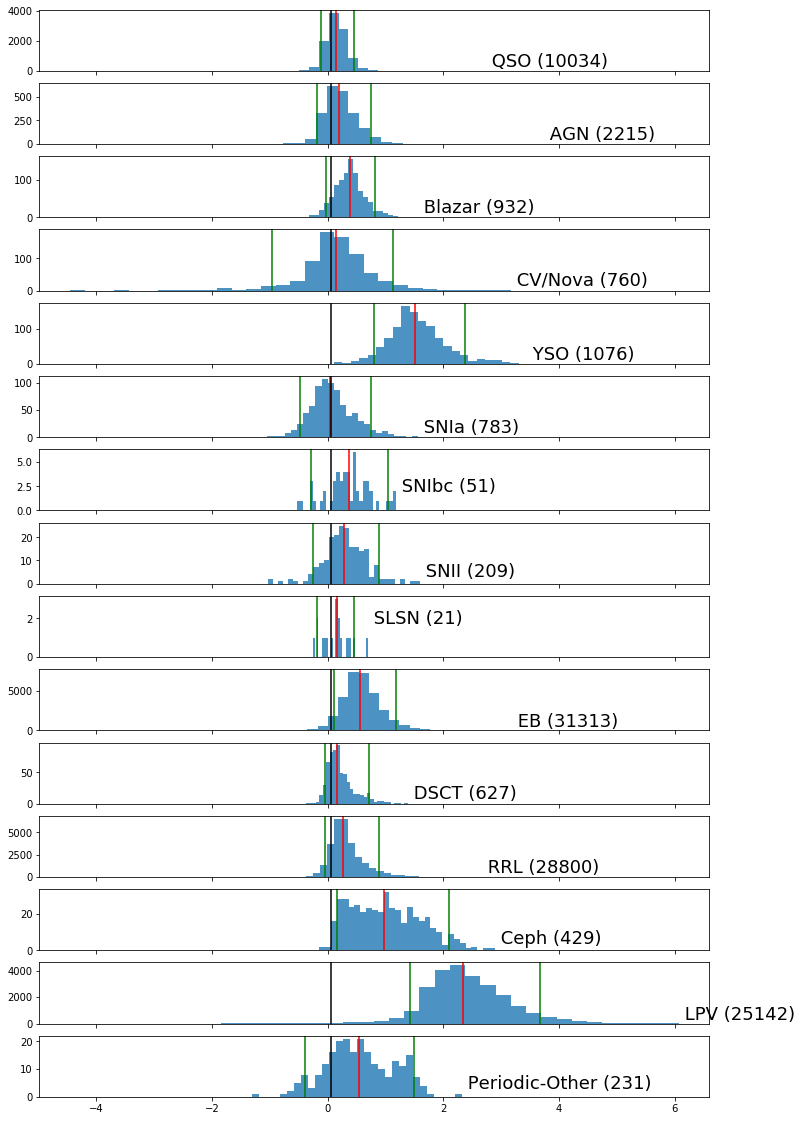

In [34]:
feature = 'g-r_mean'
logscale = False
df_train_plot = df_train#.join(labels)
df_train_plot = df_train_plot.loc[df_train_plot[feature]>-999] 
fig, ax = plt.subplots(nrows = len(label_order), figsize=(12, 20), sharex=True)

for idx, cl in enumerate(label_order):
   #print(idx, cl)

   print(cl, "%0.2f" % np.mean(df_train_plot[feature][df_train_plot['class_original']==cl].values))
   #print(idx, cl, np.percentile(df_train_plot[feature][df_train_plot['class_original']==cl].values, 50.))
   ax[idx].axvline(np.percentile(df_train_plot[feature][df_train_plot['class_original']==cl].values, 5.), c='g')
   ax[idx].axvline(np.percentile(df_train_plot[feature][df_train_plot['class_original']==cl].values, 50.), c='r')
   ax[idx].axvline(np.percentile(df_train_plot[feature][df_train_plot['class_original']==cl].values, 95.), c='g')
   ax[idx].axvline(1/len(prob_final_class_names_ul), c = 'k')
   if logscale: 
      feat = np.log10(df_train_plot[feature][df_train_plot['class_original']==cl].values)
      feat = feat[feat>0]
      ax[idx].hist(np.log10(df_train_plot[feature][df_train_plot['class_original']==cl].values), density=False, bins=30, lw=5, label=cl, alpha=0.8)
   else: ax[idx].hist(df_train_plot[feature][df_train_plot['class_original']==cl].values, density=False, bins=30, lw=5, label=cl, alpha=0.8)
   ax[idx].text(df_train_plot[feature][df_train_plot['class_original']==cl].max(), 1.5, " %s (%i)" % (cl, df_train_plot[feature][df_train_plot['class_original']==cl].shape[0]), fontsize=18, va='bottom', ha='left')

#plt.savefig('../feature_analysis_train_set/'+feature+'.pdf')

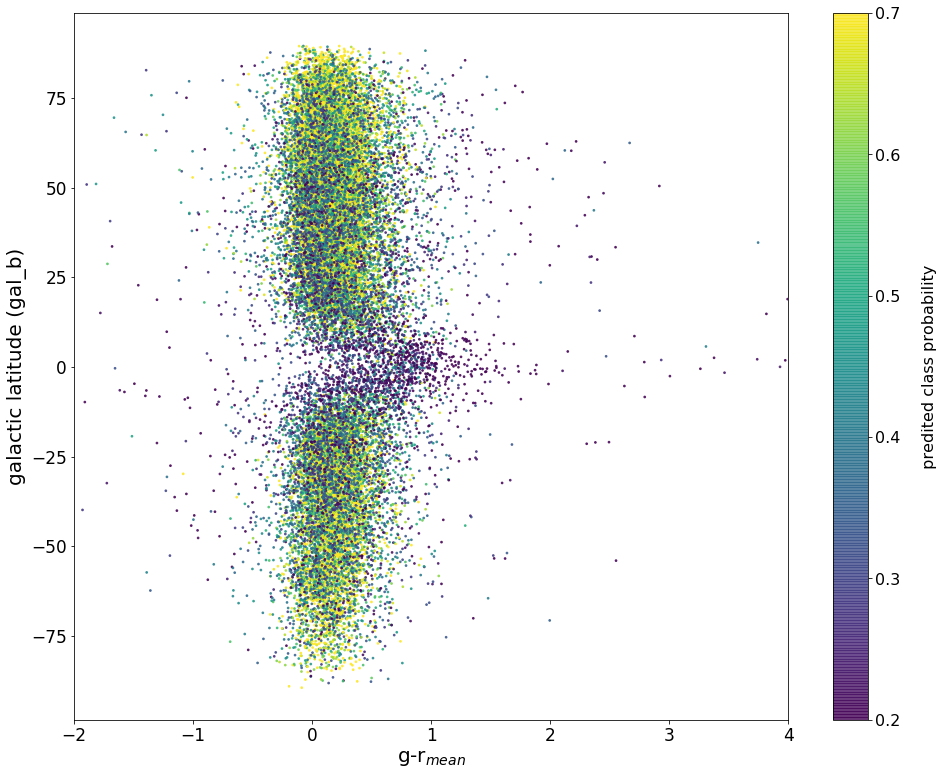

In [107]:
import matplotlib.cm as cm

feature_x = 'g-r_mean'
feature_y = 'gal_b'
#labels_list = ['RS-CVn','Ceph','LPV','RRL','AGN-I','Blazar','SNIa']
labels_list = ['QSO','AGN','Blazar','SLSN','SNII','SNIa','SNIbc']#,'LPV']
#labels_list = ['Blazar']
logscale = False
colors = cm.rainbow(np.linspace(0, 1, len(labels_list)))
#df_train = df_train.join(labels)
df_test = test_data_withclass.loc[(test_data_withclass[feature_y]>-999) & (test_data_withclass[feature_x]>-999)] 

fig, ax = plt.subplots(figsize=(16, 13))
ax.set_xlim(-2,4)

cm = plt.cm.get_cmap('viridis')

for idx, cl in enumerate(labels_list):
   #print(idx, cl)c=t
   #ax.scatter(df_test[feature_x][df_test['predicted_class']==cl].values,df_test[feature_y][df_test['predicted_class']==cl].values,color=colors[idx],alpha = 0.65, s = 3,label=cl)
   sc = ax.scatter(df_test[feature_x][df_test['predicted_class']==cl].values,df_test[feature_y][df_test['predicted_class']==cl].values,c=df_test['predicted_class_proba'][df_test['predicted_class']==cl].values,vmin=0.2, vmax=0.7,cmap=cm,alpha = 0.8, s = 3,label=cl)

cbar = plt.colorbar(sc)
cbar.set_label('\n predited class probability ', rotation=90,fontsize=16)

#plt.legend(fontsize=15)
plt.xlabel(r'g-r$_{mean}$',fontsize=20)
plt.ylabel(r'galactic latitude (gal_b)',fontsize=20) 

plt.xticks(fontsize = 17)
plt.yticks(fontsize = 17)

plt.gca().set_rasterized(True)
cbar.ax.set_yticklabels([0.2,0.3,0.4,0.5,0.6,0.7],fontsize=16)

plt.savefig('../../paper_late_classifier/paper_plots/color_gal_b_selection_extragalactic.pdf',bbox_inches='tight',dpi=200)

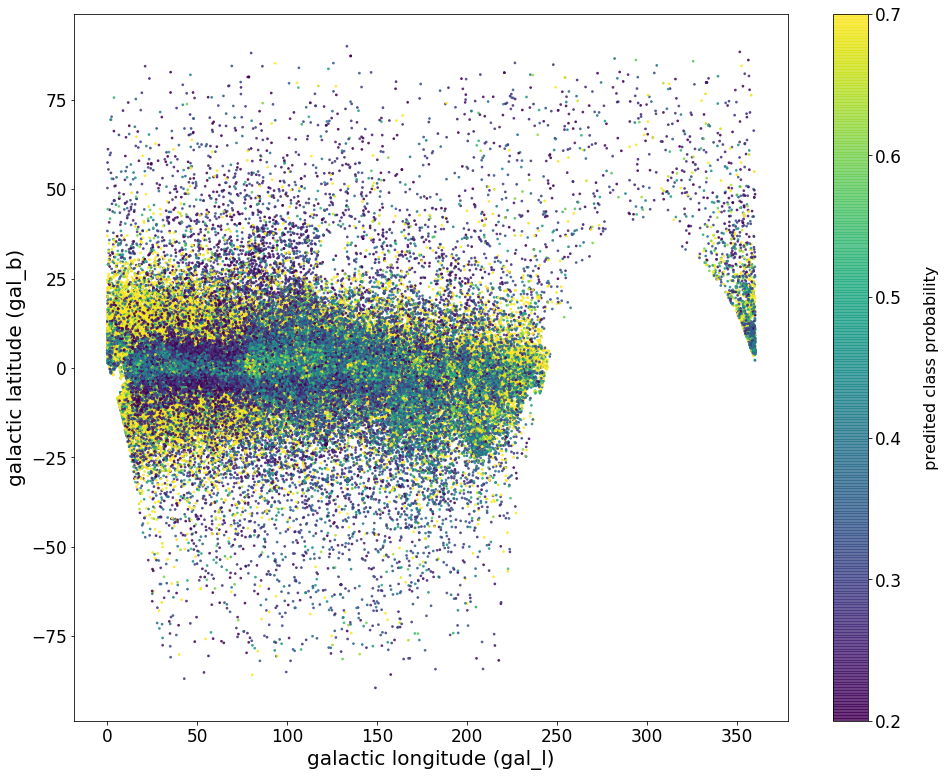

In [72]:
import matplotlib.cm as cm

feature_x = 'gal_l'
feature_y = 'gal_b'
#labels_list = ['RS-CVn','Ceph','LPV','RRL','DSCT','Periodic-Other','CV/Nova','YSO']
labels_list = ['Ceph','LPV','YSO']
#labels_list = ['QSO','AGN','Blazar','SLSN','SNII','SNIa','SNIbc']#,'LPV']
#labels_list = ['Blazar']
logscale = False
colors = cm.rainbow(np.linspace(0, 1, len(labels_list)))
#df_train = df_train.join(labels)
df_test = test_data_withclass.loc[(test_data_withclass[feature_y]>-999) & (test_data_withclass[feature_x]>-999)] 

fig, ax = plt.subplots(figsize=(16, 13))
#ax.set_xlim(-2,4)

cm = plt.cm.get_cmap('viridis')

for idx, cl in enumerate(labels_list):
   #print(idx, cl)c=t
   #ax.scatter(df_test[feature_x][df_test['predicted_class']==cl].values,df_test[feature_y][df_test['predicted_class']==cl].values,color=colors[idx],alpha = 0.65, s = 3,label=cl)
   sc = ax.scatter(df_test[feature_x][df_test['predicted_class']==cl].values,df_test[feature_y][df_test['predicted_class']==cl].values,c=df_test['predicted_class_proba'][df_test['predicted_class']==cl].values,vmin=0.2, vmax=0.7,cmap=cm,alpha = 0.8, s = 3,label=cl)
   ax.tick_params(labelsize=12)  
    
cbar = plt.colorbar(sc)
cbar.set_label('\n predited class probability ', rotation=90,fontsize=16)

#plt.legend(fontsize=15)
plt.xlabel(r'galactic longitude (gal_l)',fontsize=20)
plt.ylabel(r'galactic latitude (gal_b)',fontsize=20) 

plt.gca().set_rasterized(True)
cbar.ax.set_yticklabels([0.2,0.3,0.4,0.5,0.6,0.7],fontsize=17)

plt.xticks(fontsize = 17)
plt.yticks(fontsize = 17)

plt.savefig('../../paper_late_classifier/paper_plots/gal_l_gal_b_selection_galactic.pdf',bbox_inches='tight',dpi=200)

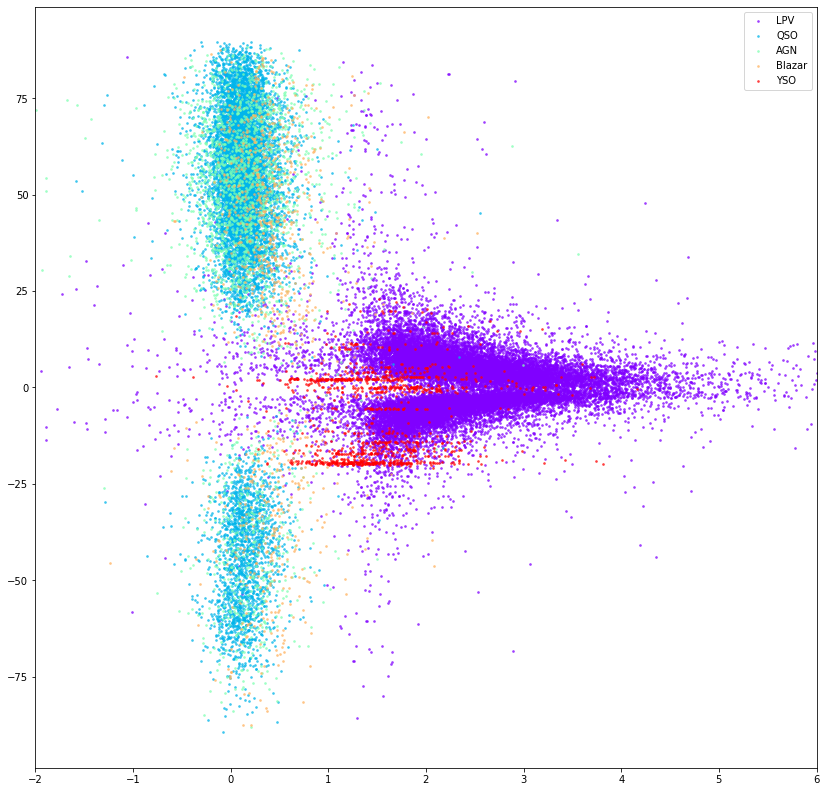

In [37]:
import matplotlib.cm as cm

feature_x = 'g-r_max'#'GP_DRW_sigma_1'
feature_y = 'gal_b' #'GP_DRW_tau_1'
labels_list = ['LPV','QSO','AGN','Blazar','YSO']
logscale = False
colors = cm.rainbow(np.linspace(0, 1, len(labels_list)))

df_plot = df.join(labels)
df_plot= df_plot.loc[(df_plot[feature_y]>-999) & (df_plot[feature_x]>-999)] 

fig, ax = plt.subplots(figsize=(14, 14))
ax.set_xlim(-2,6)
#ax.set_xlim(-4,3)
#ax.set_ylim(-4,5)
for idx, cl in enumerate(labels_list):
   #print(idx, cl)
   ax.scatter(df_plot[feature_x][df_plot['class_original']==cl].values,df_plot[feature_y][df_plot['class_original']==cl].values,color=colors[idx],alpha=0.6,s = 3,label=cl)
   #ax.scatter(np.log10(df_plot[feature_x][df_plot['class_original']==cl].values),np.log10(df_plot[feature_y][df_plot['class_original']==cl].values),color=colors[idx],alpha=0.6,label=cl)
   
plt.legend()
#plt.savefig('../feature_analysis_train_set/'+feature+'.pdf')

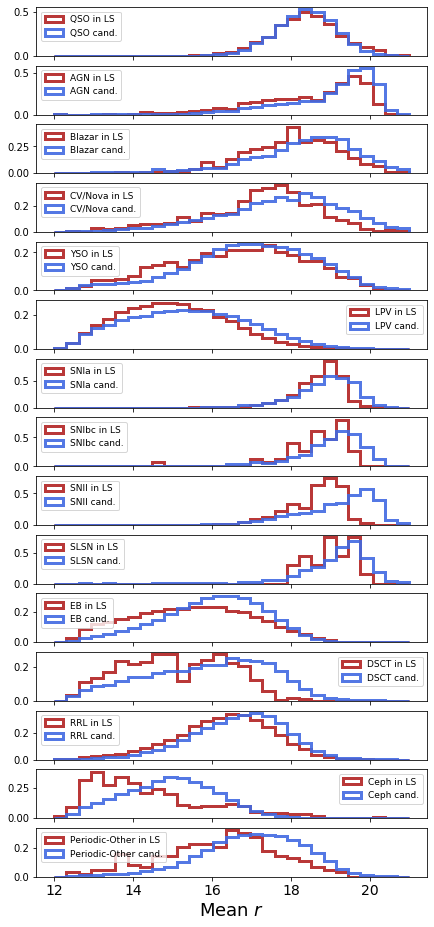

In [108]:

feature = 'Mean_2'
logscale = False
df_train_plot = df_train#.join(labels)
df_train_plot = df_train_plot.loc[df_train_plot[feature]>-999] 
#fig, ax = plt.subplots(nrows = int(len(label_order)/2)+1,ncols=2, figsize=(20, 24), sharex=True)
fig, ax = plt.subplots(nrows = len(label_order),ncols=1, figsize=(7,16), sharex=True)


bins_hist = np.linspace(12,21,30)
label_order = ['QSO','AGN', 'Blazar', 'CV/Nova', 'YSO','LPV', 'SNIa', 'SNIbc', 'SNII',
               'SLSN', 'EB', 'DSCT', 'RRL', 'Ceph','Periodic-Other']


for idx, cl in enumerate(label_order):
   
   if idx<=14:
       ax[idx].hist(df_train_plot[feature][df_train_plot['class_original']==cl].values, cumulative=False, density=True, histtype='step', bins=bins_hist, lw=3, color = "firebrick", ec="firebrick",label=cl+' in LS', alpha=0.9)
       ax[idx].hist(test_data_withclass[feature][test_data_withclass['predicted_class']==cl].values, cumulative=False, density=True, histtype='step', bins=bins_hist, lw=3, color = "royalblue", ec="royalblue",label=cl+' cand.', alpha=0.9)
       if ((cl=="DSCT") | (cl=="Ceph") | (cl=="LPV") ): ax[idx].legend(loc='upper right',fontsize=9)
       else: ax[idx].legend(loc='upper left',fontsize=9)
   #elif idx<=14:
       #ax[idx-8,1].hist(df_train_plot[feature][df_train_plot['class_original']==cl].values, cumulative=False, density=True, histtype='step', bins=bins_hist, lw=3, color = "firebrick", ec="firebrick",label=cl+' in LS', alpha=0.9)
       #ax[idx-8,1].hist(test_data_withclass[feature][test_data_withclass['predicted_class']==cl].values, cumulative=False, density=True, histtype='step', bins=bins_hist, lw=3, color = "royalblue", ec="royalblue",label='predicted '+cl, alpha=0.9)
       #ax[idx-8,1].legend(loc='upper left',fontsize=12)
   else:
        break

 
#ax[7,1].hist(df_train_plot[feature].values, cumulative=False, density=True, histtype='step', bins=bins_hist, lw=3, color = "firebrick", ec="firebrick",label='all in LS', alpha=0.9)
#ax[7,1].hist(test_data_withclass[feature].values, cumulative=False, density=True, histtype='step', bins=bins_hist, lw=3, color = "royalblue", ec="royalblue",label='all predicted ', alpha=0.9)
#ax[7,1].legend(loc='upper left',fontsize=12)

ax[len(label_order)-1].set_xlabel(r'Mean $r$',fontsize=18)
#ax[7,1].set_xlabel('Mean r',fontsize=20)    
plt.xticks(fontsize = 14)

plt.savefig('../../paper_late_classifier/paper_plots/Rband_magnitude_dist.pdf',bbox_inches='tight')





[9.50707909e-01 4.23006301e-13 5.79546595e-01 ... 5.08670118e-01
 3.35335326e-04 7.51286755e-03]


/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:908: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


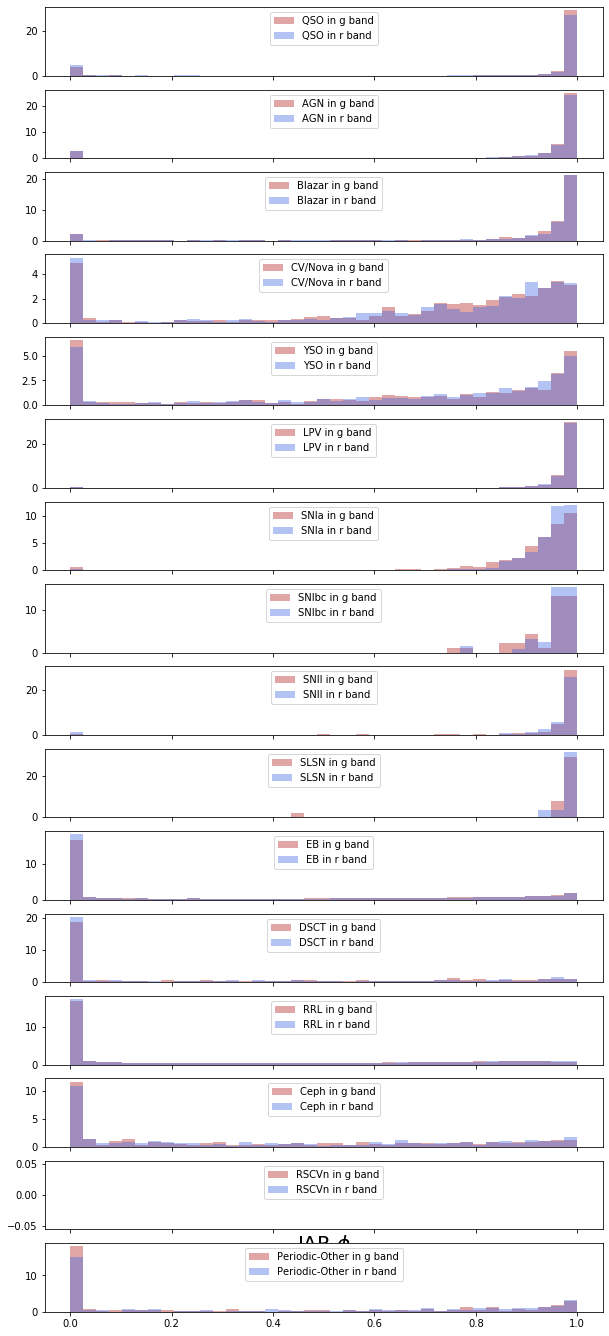

In [39]:
feature1 = 'IAR_phi_1'
feature2 = 'IAR_phi_2'
logscale = False
df_train_plot = df_train#.join(labels)
df_train_plot1 = df_train_plot.loc[df_train_plot[feature1]>-999] 
df_train_plot2 = df_train_plot.loc[df_train_plot[feature2]>-999] 

print(df_train_plot2[feature2].values)
#label_order_aux = ['QSO','AGN', 'Blazar', 'CV/Nova', 'YSO','LPV', 'SNIa', 'SNIbc', 'SNII',
#               'SLSN', 'EA', 'EB/EW', 'DSCT', 'RRL', 'Ceph','RSCVn','Periodic-Other']
label_order_aux = ['QSO','AGN', 'Blazar', 'CV/Nova', 'YSO','LPV', 'SNIa', 'SNIbc', 'SNII',
               'SLSN', 'EB', 'DSCT', 'RRL', 'Ceph','RSCVn','Periodic-Other']

fig, ax = plt.subplots(nrows = len(label_order_aux), figsize=(10, 24), sharex=True)

bins_hist = np.linspace(0,1.0001,40)

for idx, cl in enumerate(label_order_aux):
   
   ax[idx].hist(df_train_plot1[feature1][df_train_plot1['class_original']==cl].values, density=True, histtype='stepfilled', bins=bins_hist, lw=5, color = "firebrick", ec=None,label=cl+' in g band', alpha=0.4)
   ax[idx].hist(df_train_plot2[feature2][df_train_plot2['class_original']==cl].values, density=True, histtype='stepfilled', bins=bins_hist, lw=5, color = "royalblue", ec=None,label=cl+' in r band', alpha=0.4)
   ax[idx].legend(loc='upper center')

ax[len(label_order)-1].set_xlabel(r'IAR $\phi$',fontsize=20)    
plt.savefig('/Users/psanchez/Desktop/IAR_dist.pdf')